In [3]:
import twstock  # https://pypi.org/project/twstock/
import matplotlib.pyplot as plt
import mplfinance as mpf    # https://github.com/matplotlib/mplfinance
import pandas as pd
import glob
import os

In [4]:
class StockData:
    name_attribute = ['Date', 'Capacity', 'Turnover', 'Open', 'High', 'Low', 'Close', 'Change', 'Transcation']

    def __init__(self, stock_code):
        self.stock_code = stock_code
        self.filename = None
        self.latest_date = None
        self.update_data()
    
    def get_latest_filename(self):
        file_pattern = f'./data/{self.stock_code}_*.csv'
        files = sorted(glob.glob(file_pattern), reverse=True)
        if files:
            self.filename = files[0]
            self.latest_date = os.path.splitext(os.path.basename(self.filename))[0].split('_')[-1]
        else:
            self.filename = None
            self.latest_date = None

    def initial_grap(self):
        stock = twstock.Stock(self.stock_code)
        price = stock.fetch_from(2020, 11)
        df = pd.DataFrame(columns=self.name_attribute, data=price)
        
        self.latest_date = pd.to_datetime(df['Date'].iloc[-1]).strftime('%Y-%m-%d')
        self.filename = f'./data/{self.stock_code}_{self.latest_date}.csv'
        df.to_csv(self.filename, date_format="%Y-%m-%d")

    def update_data(self):
        self.get_latest_filename()
        if not self.filename:
            self.initial_grap()
            return

        df = pd.read_csv(self.filename, index_col=0, dtype={'Date': str})
        
        last_date = pd.to_datetime(self.latest_date)
        stock = twstock.Stock(self.stock_code)
        new_price = stock.fetch_from(last_date.year, last_date.month)
        
        new_df = pd.DataFrame(columns=df.columns, data=new_price)
        new_df = new_df[new_df['Date'] > self.latest_date]
        new_df['Date'] = new_df['Date'].astype(str)
        
        if not new_df.empty:
            last_index = df.index.max() + 1 if not df.empty else 1
            new_df.index = range(last_index, last_index + len(new_df))
            df = pd.concat([df, new_df])
            
            self.latest_date = new_df['Date'].iloc[-1]
            self.filename = f'./data/{self.stock_code}_{self.latest_date}.csv'
            df.to_csv(self.filename, index=True, date_format="%Y-%m-%d")

    def get_last_days_entries(self,days):
        if not self.filename:
            self.get_latest_filename()
        if self.filename:
            df = pd.read_csv(self.filename, index_col=0)
            return df.tail(days)
        else:
            print("No data file found.")
            return None

In [17]:
class StockChart:
    def __init__(self, stock_data):
        self.stock_data = stock_data
        self.filename = stock_data.filename

    def load_data(self):
        if self.filename:
            df = pd.read_csv(self.filename, index_col=0)
            df['Date'] = pd.to_datetime(df['Date'])
            df.set_index('Date', inplace=True)
            return df
        else:
            print("No data file found.")
            return None

    def print_k_chart(self, days=365):
        df = self.load_data()
        if df is not None:
            df = df.tail(days)
            df.rename(columns={'Turnover': 'Volume'}, inplace=True)

            mc = mpf.make_marketcolors(up='r', down='g', inherit=True)
            s = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)

            kwargs = dict(
                type='candle',
                mav=(5, 20, 60),
                volume=True,
                figratio=(10, 8),
                figscale=0.75,
                title=f"K chart: Last {days} days ({self.stock_data.stock_code})",
                style=s
            )
            mpf.plot(df, **kwargs)
        else:
            print("df is empty")
    
    def print_last_days_closes(self, days=20):
        df = self.load_data()
        if df is not None and 'Close' in df.columns:
            last_closes = df['Close'].tail(days)
            plt.figure(figsize=(10, 5))
            plt.plot(last_closes.index, last_closes.values, marker='.', linestyle='-', color='b')
            plt.title(f"Last {days} Closes ({self.stock_data.stock_code})")
            plt.xlabel("Date")
            plt.ylabel("Close Price")
            plt.xticks(rotation=45)
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            # plt.savefig(f'./results/({self.stock_data.stock_code})last_{days}_closes.jpg')
        else:
            print("No 'Close' column in data.")

In [18]:
# stock_code = input('Please input stock code: ')
stock_code = '0050'
stock_data = StockData(stock_code)
stock_chart = StockChart(stock_data)

print(f"latest file: {stock_data.filename}")
print(f"latest date: {stock_data.latest_date}")


latest file: ./data/0050_2024-12-09.csv
latest date: 2024-12-09


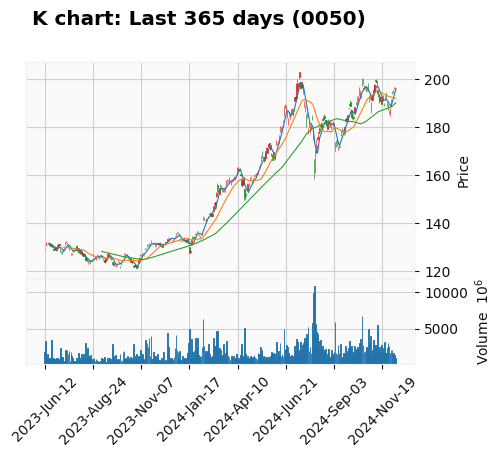

In [19]:
stock_chart.print_k_chart()

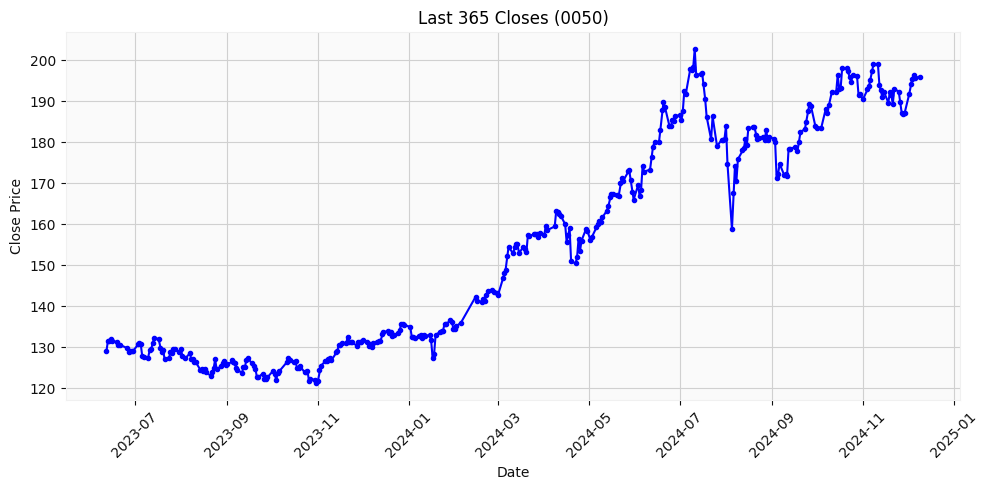

In [20]:
stock_chart.print_last_days_closes(365)